<a href="https://colab.research.google.com/github/pradyyyy/technology-readiness-index/blob/main/technology-readiness-index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import random

from google.colab import auth
import gspread
from google.auth import default

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Functions

In [ ]:
#autenticating ke google
auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)


# untuk membaca dataset 
def read_data(data):
  worksheet = gc.open(data).sheet1

  # semua values dijadikan sebagai list rows
  rows = worksheet.get_all_values()

  # convert to dataframe
  df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
  return df


# untuk mengganti nama column 
def rename_columns(data):
  for i in range(len(data.columns)):
    splitted = data.columns[i].split(" -")
    new_col = splitted[0]
    data.columns = data.columns.str.replace(data.columns[i], new_col)
  return data


# untuk reverse scala likert pada dataframe 
def reverse_likert(data):
  result = pd.DataFrame()
  for i in range(len(data.columns)):
    columnName = data.columns[i]
    array_reverse = []
    # sebelum looping kolom
    for label, content in data.iterrows():
      value = content[columnName]
      if value == 1:
        array_reverse.append(5)
      if value == 2:
        array_reverse.append(4)
      if value == 3:
        array_reverse.append(3)
      if value == 4:
        array_reverse.append(2)
      if value == 5:
        array_reverse.append(1)
    # setelah looping kolom
    result[columnName] = array_reverse
  return result


# menggabungkan dataframe yang asli dan dataframe yang sudah di lakukan reverse skala Likert 
def append_reverse_likert_to_main_dataframe(main_df, reverse_likert):
  result = main_df
  for i in range(len(reverse_likert.columns)):
    columnName = reverse_likert.columns[i]
    result[columnName] = reverse_likert[columnName].values
    # print(reverse_likert[columnName].values)
  return result

In [ ]:
# menghitung sum tiap variabel 
def sum_variable(data):
  result = pd.DataFrame()
  major_columns = ['OPT', 'INO', 'DIS', 'INS']
  array_sum_OPT = []
  array_sum_INO = []
  array_sum_DIS = []
  array_sum_INS = []

  # loop per rows
  for label, content in data.iterrows():
    # data yang diloop udah per rows
    sum_rows = [0, 0, 0, 0]
    # looping item di dalam row
    for series_column, value in content.iteritems():
      # looping major columns
      for i in range(len(major_columns)):
        # kalau nama kolomnya sama dengan major columns, dijumlahkan hasilnya
        if major_columns[i] in series_column:
          sum_rows[i] = sum_rows[i] + value
    # print(sum_rows)

    array_sum_OPT.append(sum_rows[0])
    array_sum_INO.append(sum_rows[1])
    array_sum_DIS.append(sum_rows[2])
    array_sum_INS.append(sum_rows[3])

  result['Total OPT'] = array_sum_OPT
  result['Total INO'] = array_sum_INO
  result['Total DIS'] = array_sum_DIS
  result['Total INS'] = array_sum_INS
  return result

# menggabungkan dataframe sum_data ke dataframe result_ujicoba_reverse
def merge_variable_with_total_score(data, sum_data):
  major_columns = ['OPT', 'INO', 'DIS', 'INS']
  df_opt = pd.DataFrame()
  df_ino = pd.DataFrame()
  df_dis = pd.DataFrame()
  df_ins = pd.DataFrame()
  # print(sum_data)
  for i in range(len(major_columns)):
    for j in range(len(data.columns)):
      # print(data.columns[j])
      if major_columns[i] in data.columns[j]: # samain nama kolom, kalo sama, masuk if
        columnName = data.columns[j]
        if major_columns[i] == 'OPT':
          df_opt[columnName] = data[columnName].values
        if major_columns[i] == 'INO':
          df_ino[columnName] = data[columnName].values
        if major_columns[i] == 'DIS':
          df_dis[columnName] = data[columnName].values
        if major_columns[i] == 'INS':
          df_ins[columnName] = data[columnName].values

  df_opt['sumOPT'] = sum_data['Total OPT'].values
  df_ino['sumINO'] = sum_data['Total INO'].values
  df_dis['sumDIS'] = sum_data['Total DIS'].values
  df_ins['sumINS'] = sum_data['Total INS'].values
  return df_opt, df_ino, df_dis, df_ins


# menghitung korelasi variabel 
def corr_coef(opt, ino, dis, ins, sum_data):
  corr_matrix_opt = opt.corr()
  corr_matrix_ino = ino.corr()
  corr_matrix_dis = dis.corr()
  corr_matrix_ins = ins.corr()
  result = [corr_matrix_opt, corr_matrix_ino, corr_matrix_dis, corr_matrix_ins]
  return result

# mengecek pengujian validitas 
def check_valid(corr_data, rtable):
  df_result_valid = pd.DataFrame()
  idx = []
  rcount = []
  list_rtable = []
  result = []

  for corr in corr_data:
    corr_value = corr.iloc[:, -1:]
    for index, content in corr_value.iterrows():
      if content[0] > rtable:
        if content[0] != 1.0:
          idx.append(index)
          rcount.append(round(content[0], 4))
          list_rtable.append(rtable)
          result.append('Valid')

  df_result_valid['Instrumen'] = idx
  df_result_valid['rcount'] = rcount
  df_result_valid['rtable'] = list_rtable
  df_result_valid['result'] = result
  return df_result_valid


# menghitung cronbach alpha 
def cronbach_alpha(data):
  new_data = data.iloc[:, :-1]
  var_data = new_data.var().tolist()
  sum_var_data = sum(var_data)

  sumdata = data.iloc[:, -1:]
  column_name = sumdata.columns.values
  slice_str_col = column_name[0][3:]
  var_sumdata = sumdata.var()

  cronbach = (len(var_data) / (len(var_data)-1)) * (1 - (sum_var_data / var_sumdata))
  return slice_str_col, cronbach[0]


# mengecek pengujian reliabelitas 
def check_realiabel(value_cronbach_alpha, req_min):
  df_result_reliabel = pd.DataFrame()
  column_name = []
  rcronbach_alpha = []
  result = []

  for keys, content in value_cronbach_alpha.items():
    if content > req_min:
      column_name.append(keys)
      rcronbach_alpha.append(round(content, 4))
      result.append('Reliabel')
      # print(keys, round(content[0], 4), ">", req_min, "=", "Reliabel")

  df_result_reliabel['Variabel'] = column_name
  df_result_reliabel['Cronbach alpha'] = rcronbach_alpha
  df_result_reliabel['Result'] = result
  return df_result_reliabel

In [ ]:
# membuat pie chart 
def create_pie_chart(data, x, y, title): 
  value = list(data.values())
  keys = list(data.keys())

  fig, ax = plt.subplots(1,1)
  fig.set_figwidth(x)
  fig.set_figheight(y)

  plt.pie(value, labels=keys, autopct='%1.1f%%')
  plt.title(title)
  return plt.show()


# membuat plot bar berdasarkan jawaban responden setiap kolom 
def plot_bar(df_responses):
  data_responses = df_responses.iloc[:, 2:]

  for col in data_responses.columns:
    dict_responses = {1:0, 2:0, 3:0, 4:0, 5:0}
    update_dict_responses = data_responses[col].value_counts().sort_index().to_dict()
    dict_responses.update(update_dict_responses)
    # print(dict_responses)

    key = list(dict_responses.keys())
    value = list(dict_responses.values())
  
    fig, ax = plt.subplots(1,1)
    sns.barplot(data=data_responses, x=key, y=value)
    plt.title('Data jawaban responden terhadap pernyataan ' + col)
    for i, v in enumerate(value):
      ax.text(i, value[i] + 0.6, value[i],  ha='center')
  return plt.show()


# membuat plot bar berdasarkan jawaban responden dan jenis kelamin 
def plot_bar_responses_and_gender(df_responses_gender): 
  data_responses_gender = df_responses_gender.iloc[:, 1:]

  for col in data_responses_gender.columns:
    dict_responses = {'Laki-laki':{1:0, 2:0, 3:0, 4:0, 5:0}, 'Perempuan':{1:0, 2:0, 3:0, 4:0, 5:0}}
    update_dict_responses = data_responses_gender[col].value_counts().sort_index().to_dict()
    # dict_responses.update(update_dict_responses)
    # print(data_responses_gender.groupby(['Jenis Kelamin', data_responses_gender[col]]).size())
    if (col != 'Jenis Kelamin') :
      update_test = data_responses_gender.groupby(['Jenis Kelamin', data_responses_gender[col]]).size().to_dict()
      key = list(update_test.keys())
      value = list(update_test.values())

      for i in key:
        jeniskelamin, nilai = i
        dict_responses[jeniskelamin][nilai] = update_test.get(i)
        # print(update_test.get(i))
        # print(jeniskelamin)
        # print(nilai)

      # print('\n', dict_responses)
      
      df_dict_responses = pd.DataFrame(dict_responses)
      ax = df_dict_responses.plot(kind='bar', title='Data jawaban responden terhadap pernyataan ' + col, rot=0)
      for p in ax.patches:
        bar_value = p.get_height()
        format_text = f'{bar_value:,}'
        text_x = p.get_x() + p.get_width() / 2
        text_y = p.get_y() + bar_value
        ax.text(text_x, text_y, format_text, ha='center', va='bottom')
  return plt.show()

In [ ]:
# menghitung rata-rata setiap pernyataan 
def mean_of_statement(data, col):
  count_1 = 0
  count_2 = 0
  count_3 = 0
  count_4 = 0
  count_5 = 0
  count_list = []
  skala_likert = [1,2,3,4,5]
  # print(skala_likert)

  for label, content in data.iterrows():
    # print(label, content)
    value = content[col]
    if value == 1:
      count_1 += 1
    if value == 2:
      count_2 += 1
    if value == 3:
      count_3 += 1
    if value == 4:
      count_4 += 1
    if value == 5:
      count_5 += 1

  count_list.append(count_1)
  count_list.append(count_2)
  count_list.append(count_3)
  count_list.append(count_4)
  count_list.append(count_5)
  # print()
  # print("List jawaban ", count_list)

  sum_list = sum(count_list)
  # print("Jumlah responden" , sum_list)

  # Menghitung list jawaban dikali dengan jumlah jawaban
  total = 0
  for i in range(len(count_list)):
    result = skala_likert[i] * count_list[i]
    total += result
  # print("Hasil perkalian " , total)

  # mean pernyataan
  mean = total/sum_list
  # print("Nilai mean ", mean)

  return mean, col


# menghitung jumlah nilai masing-masing variabel 
def sum_columns(data):
  total_opt_statement = 0
  total_ino_statement = 0
  total_dis_statement = 0
  total_ins_statement = 0

  for i in range(len(data.columns)):
    if 'OPT' in data.columns[i]:
      total_opt_statement += 1
    if 'INO' in data.columns[i]:
      total_ino_statement += 1
    if 'DIS' in data.columns[i]:
      total_dis_statement += 1
    if 'INS' in data.columns[i]:
      total_ins_statement += 1

  return total_opt_statement, total_ino_statement, total_dis_statement, total_ins_statement


# menghitung bobot pernyataan masing-masing variabel 
def quality_of_statement(data):
  percent_of_statement = 25/100

  bobot_opt = percent_of_statement / count_columns_variables[0]
  bobot_ino = percent_of_statement / count_columns_variables[1]
  bobot_dis = percent_of_statement / count_columns_variables[2]
  bobot_ins = percent_of_statement / count_columns_variables[3]

  return bobot_opt, bobot_ino, bobot_dis, bobot_ins


# nilai setiap pernyataan 
def value_of_statement(data):
  list_bobot = []
  for i in range(count_columns_variables[0]):
    list_bobot.append(variables_quality[0])
  for i in range(count_columns_variables[1]):
    list_bobot.append(variables_quality[1])
  for i in range(count_columns_variables[2]):
    list_bobot.append(variables_quality[2])
  for i in range(count_columns_variables[3]):
    list_bobot.append(variables_quality[3])

  # print(list_bobot)
  # print(result_mean)

  #Mengalikan hasil mean dengan bobot pernyataan
  new_result = {}
  number = 0
  for label, value in data.items():
    result = value * list_bobot[number]
    new_result[label] = result
    number += 1

  return new_result

In [ ]:
clr_palette = ['#e80d79', '#e00de8', '#1c0de8', '#0db7e8', '#0de846', '#e5e80d', '#e8650d', '#e80d0d', '#74093e', '#871f8b', '#0f0783', '#0c7b9b', '#098429', '#95970d', '#a84f12', '#af0808']


# membuat plot bar rata-rata setiap kolom
def create_plot_bar(data, x, y, color_palette):
  value = list(data.values())
  keys = list(data.keys())

  fig, ax = plt.subplots(1,1)
  fig.set_figwidth(x)
  fig.set_figheight(y)

  plt.bar(range(len(data)), value, color=color_palette)
  plt.xticks(range(len(data)), keys)
  for i, v in enumerate(value):
    ax.text(i, value[i] + 0.003 , str(round(value[i], 3)), ha='center')

  return plt.show()


# menghitung nilai TRI berdasarkan variabel 
def value_variable(data):
  iterator = []
  iterator.append(count_columns_variables[0])
  iterator.append(count_columns_variables[1])
  iterator.append(count_columns_variables[2])
  iterator.append(count_columns_variables[3])
  iterator_index = 0
  pointer = 0 # untuk penanda
  partial_result = 0
  sum_result = {}

  for label, value in data.items():
    new_label = label[:-1]
    partial_result += value
    pointer += 1
    if pointer == iterator[iterator_index]:
      sum_result[new_label] = round(partial_result, 3)
      iterator_index += 1
      pointer = 0
      partial_result = 0

  return sum_result


# menentukan indeks TRI 
def check_value_TRI(data):
  if data <= 2.82:
    print("Nilai TRI ", data, "-> low technology readiness" )
  elif 2.83 <= data <= 3.24:
    print("Nilai TRI ", data, "-> medium technology readiness")
  else:
    print("Nilai TRI ", data, "-> high technology readiness")

  return data


# indeks TRI berdasarkan nilai rata-rata variabel 
def TRI_value_of_the_average_variable_value(merge_dataframe): 
  mean_data = merge_dataframe.mean()
  mean_data = mean_data.to_frame().T
  # print(mean_data)

  mean_opt = []
  mean_ino = [] 
  mean_dis = [] 
  mean_ins = [] 
  list_result_mean = []

  for label, content in mean_data.iteritems(): 
    if 'OPT' in label:
      mean_opt.append(content[0])
    if 'INO' in label:
      mean_ino.append(content[0])
    if 'DIS' in label:
      mean_dis.append(content[0])
    if 'INS' in label:
      mean_ins.append(content[0])

  result_opt = sum(mean_opt)/len(mean_opt)
  result_ino = sum(mean_ino)/len(mean_ino)
  result_dis = sum(mean_dis)/len(mean_dis)
  result_ins = sum(mean_ins)/len(mean_ins)

  list_result_mean.append(result_opt)
  list_result_mean.append(result_ino)
  list_result_mean.append(result_dis)
  list_result_mean.append(result_ins)

  # print(result_opt)
  # print(result_ino)
  # print(result_dis)
  # print(result_ins)

  # print('list result mean ', list_result_mean)

  TRI_value = round(sum(list_result_mean)/len(list_result_mean), 3)
 
  return TRI_value

In [ ]:
# menghitung euclidean distance 
def euclidean_distance(x1, x2):
  x1 = np.array(x1)
  x2 = np.array(x2)
  return np.sqrt(np.sum((x1-x2)**2))

# Uji Coba Kuesioner 

---

Dataset uji coba kuesioner ini merupakan hasil penyebaran kuesioner ke responden diluar sampel penelitian untuk mengetahui validitas dan reliabilitas instrumen pernyataan. 



## Import Dataset Uji Coba

In [ ]:
df_ujicoba = read_data('Merge Uji Coba Google Form Kuesioner Skipsi')

In [ ]:
df_ujicoba

,Timestamp,Nama,NIM,Program Studi,Angkatan,Jenis Kelamin,OPT1 - Penggunaan sistem peringatan dini kelulusan mata kuliah mempermudah saya untuk memantau hasil belajar dalam mengikuti mata kuliah.,OPT2 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya leluasa dalam mempelajari mata kuliah yang saya ikuti.,OPT3 - Penggunaan sistem peringatan dini kelulusan mata kuliah lebih efisien dalam mengatur jadwal dan pola belajar untuk meningkatkan hasil belajar saya.,OPT4 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya lebih produktif dalam mempelajari mata kuliah yang saya ikuti.,...,INO3 - Saya mengikuti perkembangan sistem peringatan dini kelulusan mata kuliah.,INO4 - Orang akan bertanya tentang sistem peringatan dini kelulusan mata kuliah kepada saya.,"DIS1 - Dalam menggunakan sistem peringatan dini kelulusan mata kuliah, saya merasa dimanfaatkan oleh pihak yang lebih menguasai tentang sistem ini.",DIS2 - Saya merasa dukungan teknis tidak banyak membantu dan sulit dimengerti.,DIS3 - Saya terkadang merasa sistem peringatan dini kelulusan mata kuliah tidak didesain untuk digunakan oleh seluruh mahasiswa.,DIS4 - Saya akan mengalami kesulitan apabila tidak terdapat panduan penggunaan sistem peringatan dini kelulusan mata kuliah yang mudah dipahami.,INS1 - Saya khawatir pengguna akan bergantung pada sistem peringatan dini kelulusan mata kuliah.,INS2 - Saya merasa khawatir jika terlalu sering menggunakan sistem peringatan dini kelulusan mata kuliah akan memberikan dampak buruk bagi pengguna.,"INS3 - Penggunaan sistem peringatan dini kelulusan mata kuliah memberikan dampak negatif, yaitu berkurangnya hubungan komunikasi saya dengan dosen serta mahasiswa lain dalam proses belajar mengajar di kelas.",INS4 - Saya merasa tidak percaya diri menggunakan sistem peringatan dini kelulusan mata kuliah yang hanya dapat diakses secara online.
0,11/1/2022 20:32:53,FN,13016*****,Pendidikan Matematika,2020,Laki - Laki,5,4,4,4,...,4,4,5,5,5,4,4,4,4,4
1,11/1/2022 20:38:14,PKN,13016*****,Pendidikan Matematika,2021,Perempuan,5,5,5,5,...,1,1,1,1,3,4,3,3,1,3
2,11/1/2022 20:41:31,W,13016*****,Pendidikan Matematika,2021,Perempuan,4,4,4,4,...,4,4,3,3,3,4,4,4,4,3
3,11/1/2022 20:41:54,AA,13016*****,Pendidikan Matematika,2021,Perempuan,4,3,4,4,...,3,3,3,4,3,4,4,4,3,3
4,11/1/2022 20:46:38,LKD,13016*****,Pendidikan Matematika,2021,Perempuan,4,3,3,4,...,3,2,3,3,4,4,4,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,11/8/2022 18:04:45,DAW,13016*****,Pendidikan Matematika,2020,Laki - Laki,5,5,5,5,...,3,3,3,2,2,4,2,2,2,3
88,11/9/2022 7:38:52,ASS,13016*****,Pendidikan Matematika,2019,Laki - Laki,5,4,5,5,...,5,4,1,2,2,5,4,4,4,2
89,11/1/2022 12:36:50,ES,,,,Perempuan,5,4,5,5,...,4,5,2,2,3,4,3,2,2,2
90,11/1/2022 14:07:47,AS,,,,Perempuan,5,4,5,4,...,4,4,2,2,2,2,2,2,2,2


## Pembersihan Dataset

In [ ]:
df_ujicoba.drop(df_ujicoba.iloc[:, 0:6], axis=1, inplace=True)

In [ ]:
df_ujicoba

,OPT1 - Penggunaan sistem peringatan dini kelulusan mata kuliah mempermudah saya untuk memantau hasil belajar dalam mengikuti mata kuliah.,OPT2 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya leluasa dalam mempelajari mata kuliah yang saya ikuti.,OPT3 - Penggunaan sistem peringatan dini kelulusan mata kuliah lebih efisien dalam mengatur jadwal dan pola belajar untuk meningkatkan hasil belajar saya.,OPT4 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya lebih produktif dalam mempelajari mata kuliah yang saya ikuti.,INO1 - Saya termasuk pengguna pertama sistem peringatan dini kelulusan mata kuliah di lingkungan saya.,INO2 - Saya mampu memahami sistem peringatan dini kelulusan mata kuliah secara mandiri.,INO3 - Saya mengikuti perkembangan sistem peringatan dini kelulusan mata kuliah.,INO4 - Orang akan bertanya tentang sistem peringatan dini kelulusan mata kuliah kepada saya.,"DIS1 - Dalam menggunakan sistem peringatan dini kelulusan mata kuliah, saya merasa dimanfaatkan oleh pihak yang lebih menguasai tentang sistem ini.",DIS2 - Saya merasa dukungan teknis tidak banyak membantu dan sulit dimengerti.,DIS3 - Saya terkadang merasa sistem peringatan dini kelulusan mata kuliah tidak didesain untuk digunakan oleh seluruh mahasiswa.,DIS4 - Saya akan mengalami kesulitan apabila tidak terdapat panduan penggunaan sistem peringatan dini kelulusan mata kuliah yang mudah dipahami.,INS1 - Saya khawatir pengguna akan bergantung pada sistem peringatan dini kelulusan mata kuliah.,INS2 - Saya merasa khawatir jika terlalu sering menggunakan sistem peringatan dini kelulusan mata kuliah akan memberikan dampak buruk bagi pengguna.,"INS3 - Penggunaan sistem peringatan dini kelulusan mata kuliah memberikan dampak negatif, yaitu berkurangnya hubungan komunikasi saya dengan dosen serta mahasiswa lain dalam proses belajar mengajar di kelas.",INS4 - Saya merasa tidak percaya diri menggunakan sistem peringatan dini kelulusan mata kuliah yang hanya dapat diakses secara online.
0,5,4,4,4,4,4,4,4,5,5,5,4,4,4,4,4
1,5,5,5,5,1,1,1,1,1,1,3,4,3,3,1,3
2,4,4,4,4,4,4,4,4,3,3,3,4,4,4,4,3
3,4,3,4,4,3,3,3,3,3,4,3,4,4,4,3,3
4,4,3,3,4,1,3,3,2,3,3,4,4,4,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,5,5,5,5,3,3,3,3,3,2,2,4,2,2,2,3
88,5,4,5,5,2,4,5,4,1,2,2,5,4,4,4,2
89,5,4,5,5,5,4,4,5,2,2,3,4,3,2,2,2
90,5,4,5,4,4,5,4,4,2,2,2,2,2,2,2,2


In [ ]:
rename_columns(df_ujicoba)

<ipython-input-4-6f63de4d8cc1>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(data.columns[i], new_col)


,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,4,4,4,4,4,4,4,5,5,5,4,4,4,4,4
1,5,5,5,5,1,1,1,1,1,1,3,4,3,3,1,3
2,4,4,4,4,4,4,4,4,3,3,3,4,4,4,4,3
3,4,3,4,4,3,3,3,3,3,4,3,4,4,4,3,3
4,4,3,3,4,1,3,3,2,3,3,4,4,4,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,5,5,5,5,3,3,3,3,3,2,2,4,2,2,2,3
88,5,4,5,5,2,4,5,4,1,2,2,5,4,4,4,2
89,5,4,5,5,5,4,4,5,2,2,3,4,3,2,2,2
90,5,4,5,4,4,5,4,4,2,2,2,2,2,2,2,2


In [ ]:
df_ujicoba = df_ujicoba.astype(int)

## Reverse Coding Skala Likert

---

Reverse coding skala Likert dilakukan karena variabel bersifat negatif. Jadi perlu dilakukan reverse score untuk variabel discomfort dan insecurity. 

In [ ]:
df_ujicoba_dis_ins = df_ujicoba.iloc[:, 8:]

In [ ]:
ujicoba_reverse = reverse_likert(df_ujicoba_dis_ins) # data hasil operasi reverse_likert
ujicoba_separate = df_ujicoba.iloc[:, :8].copy() # data awal yang tidak direverse
print("data awal yang ga di reverse")
print(ujicoba_separate)

print("\ndata hasil dari reverse")
print(ujicoba_reverse)
print('\nini hasil penggabungan kedua dataframe')

result_ujicoba_reverse = append_reverse_likert_to_main_dataframe(ujicoba_separate, ujicoba_reverse)
print(result_ujicoba_reverse)

data awal yang ga di reverse
    OPT1  OPT2  OPT3  OPT4  INO1  INO2  INO3  INO4
0      5     4     4     4     4     4     4     4
1      5     5     5     5     1     1     1     1
2      4     4     4     4     4     4     4     4
3      4     3     4     4     3     3     3     3
4      4     3     3     4     1     3     3     2
..   ...   ...   ...   ...   ...   ...   ...   ...
87     5     5     5     5     3     3     3     3
88     5     4     5     5     2     4     5     4
89     5     4     5     5     5     4     4     5
90     5     4     5     4     4     5     4     4
91     4     3     4     3     4     4     3     4

[92 rows x 8 columns]

data hasil dari reverse
    DIS1  DIS2  DIS3  DIS4  INS1  INS2  INS3  INS4
0      1     1     1     2     2     2     2     2
1      5     5     3     2     3     3     5     3
2      3     3     3     2     2     2     2     3
3      3     2     3     2     2     2     3     3
4      3     3     2     2     2     2     1     2
..   

In [ ]:
result_ujicoba_reverse

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,4,4,4,4,4,4,4,1,1,1,2,2,2,2,2
1,5,5,5,5,1,1,1,1,5,5,3,2,3,3,5,3
2,4,4,4,4,4,4,4,4,3,3,3,2,2,2,2,3
3,4,3,4,4,3,3,3,3,3,2,3,2,2,2,3,3
4,4,3,3,4,1,3,3,2,3,3,2,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,5,5,5,5,3,3,3,3,3,4,4,2,4,4,4,3
88,5,4,5,5,2,4,5,4,5,4,4,1,2,2,2,4
89,5,4,5,5,5,4,4,5,4,4,3,2,3,4,4,4
90,5,4,5,4,4,5,4,4,4,4,4,4,4,4,4,4


In [ ]:
result_ujicoba_reverse.to_excel("result_ujicoba_reverse.xlsx")  

In [ ]:
result_sum_variable_ujicoba = sum_variable(result_ujicoba_reverse)
print(result_sum_variable_ujicoba)

    Total OPT  Total INO  Total DIS  Total INS
0          17         16          5          8
1          20          4         15         14
2          16         16         11          9
3          15         12         10         10
4          14          9         10          7
..        ...        ...        ...        ...
87         20         12         13         15
88         19         15         14         10
89         19         18         13         15
90         18         17         16         16
91         14         15         15         16

[92 rows x 4 columns]


## Uji Validitas dan Reliabilitas

### Uji Validitas

In [ ]:
opt, ino, dis, ins = merge_variable_with_total_score(result_ujicoba_reverse, result_sum_variable_ujicoba)
# print(opt, '\n', ino, '\n', dis, '\n', ins)

In [ ]:
corr_data = corr_coef(opt, ino, dis, ins, result_sum_variable_ujicoba)

In [ ]:
check_valid(corr_data, 0.2050)

,Instrumen,rcount,rtable,result
0,OPT1,0.8195,0.205,Valid
1,OPT2,0.8351,0.205,Valid
2,OPT3,0.8209,0.205,Valid
3,OPT4,0.7902,0.205,Valid
4,INO1,0.8899,0.205,Valid
5,INO2,0.8569,0.205,Valid
6,INO3,0.8774,0.205,Valid
7,INO4,0.8709,0.205,Valid
8,DIS1,0.7785,0.205,Valid
9,DIS2,0.7652,0.205,Valid


### Uji Reliabilitas

In [ ]:
cronbach_alpha = dict([cronbach_alpha(opt), cronbach_alpha(ino), cronbach_alpha(dis), cronbach_alpha(ins)])

In [ ]:
check_realiabel(cronbach_alpha, 0.6)

,Variabel,Cronbach alpha,Result
0,OPT,0.8302,Reliabel
1,INO,0.8915,Reliabel
2,DIS,0.6971,Reliabel
3,INS,0.8675,Reliabel


# Analisis Data Penelitian 

---

Dataset yang digunakan pada bagian ini merupakan hasil penyebaran kuesioner ke responden di lingkup sampel penelitian untuk mencapai tujuan penelitian. 

## Import Dataset 

In [ ]:
df_dataset = read_data('Merge Google Form Kuesioner skipsi')

In [ ]:
df_dataset

,Timestamp,Email,Nama,NIM,Program Studi,Kategori,Jenis Kelamin,OPT1 - Penggunaan sistem peringatan dini kelulusan mata kuliah mempermudah saya untuk memantau hasil belajar dalam mengikuti mata kuliah.,OPT2 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya leluasa dalam mempelajari mata kuliah yang saya ikuti.,OPT3 - Penggunaan sistem peringatan dini kelulusan mata kuliah lebih efisien dalam mengatur jadwal dan pola belajar untuk meningkatkan hasil belajar saya.,...,INO3 - Saya mengikuti perkembangan sistem peringatan dini kelulusan mata kuliah.,INO4 - Orang akan bertanya tentang sistem peringatan dini kelulusan mata kuliah kepada saya.,"DIS1 - Dalam menggunakan sistem peringatan dini kelulusan mata kuliah, saya merasa dimanfaatkan oleh pihak yang lebih menguasai tentang sistem ini.",DIS2 - Saya merasa dukungan teknis tidak banyak membantu dan sulit dimengerti.,DIS3 - Saya terkadang merasa sistem peringatan dini kelulusan mata kuliah tidak didesain untuk digunakan oleh seluruh mahasiswa.,DIS4 - Saya akan mengalami kesulitan apabila tidak terdapat panduan penggunaan sistem peringatan dini kelulusan mata kuliah yang mudah dipahami.,INS1 - Saya khawatir pengguna akan bergantung pada sistem peringatan dini kelulusan mata kuliah.,INS2 - Saya merasa khawatir jika terlalu sering menggunakan sistem peringatan dini kelulusan mata kuliah akan memberikan dampak buruk bagi pengguna.,"INS3 - Penggunaan sistem peringatan dini kelulusan mata kuliah memberikan dampak negatif, yaitu berkurangnya hubungan komunikasi saya dengan dosen serta mahasiswa lain dalam proses belajar mengajar di kelas.",INS4 - Saya merasa tidak percaya diri menggunakan sistem peringatan dini kelulusan mata kuliah yang hanya dapat diakses secara online.
0,11/9/2022 10:22:23,a**********.com,AFS,13136*****,Ilmu Komputer,2020,Laki-laki,5,5,4,...,1,2,5,2,2,2,5,1,5,4
1,11/9/2022 10:22:31,a**********.com,ALP,13136*****,Ilmu Komputer,2020,Laki-laki,5,5,5,...,5,3,4,3,2,4,4,2,3,4
2,11/9/2022 10:30:54,g**********.com,GK,13136*****,Ilmu Komputer,2020,Laki-laki,3,4,5,...,2,1,5,3,5,5,5,5,5,5
3,11/9/2022 10:32:02,h**********.com,RH,13136*****,Ilmu Komputer,2020,Laki-laki,5,5,4,...,3,2,2,2,2,2,2,2,2,2
4,11/9/2022 10:40:17,i**********.com,IAT,13136*****,Ilmu Komputer,2020,Laki-laki,5,4,5,...,3,2,3,4,3,3,3,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,11/28/2022 18:35:53,n**********.com,NAM,13136*****,Ilmu Komputer,2019,Laki-laki,5,1,5,...,4,4,5,5,1,5,1,2,4,4
151,11/15/2022 11:07:08,a**********.com,FHI,,,,Perempuan,5,2,5,...,4,4,3,4,4,4,4,4,4,4
152,11/16/2022 21:01:04,r**********c.id,RA,,,,Perempuan,5,5,5,...,5,5,2,2,1,2,2,1,1,2
153,11/18/2022 15:46:29,e**********c.id,MES,,,,Laki-laki,3,3,3,...,1,1,3,3,3,3,2,2,2,2


## Pembersihan Dataset

In [ ]:
df_dataset.drop(df_dataset.iloc[:, :5], axis=1, inplace=True)

In [ ]:
df_dataset

,Kategori,Jenis Kelamin,OPT1 - Penggunaan sistem peringatan dini kelulusan mata kuliah mempermudah saya untuk memantau hasil belajar dalam mengikuti mata kuliah.,OPT2 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya leluasa dalam mempelajari mata kuliah yang saya ikuti.,OPT3 - Penggunaan sistem peringatan dini kelulusan mata kuliah lebih efisien dalam mengatur jadwal dan pola belajar untuk meningkatkan hasil belajar saya.,OPT4 - Penggunaan sistem peringatan dini kelulusan mata kuliah membuat saya lebih produktif dalam mempelajari mata kuliah yang saya ikuti.,INO1 - Saya termasuk pengguna pertama sistem peringatan dini kelulusan mata kuliah di lingkungan saya.,INO2 - Saya mampu memahami sistem peringatan dini kelulusan mata kuliah secara mandiri.,INO3 - Saya mengikuti perkembangan sistem peringatan dini kelulusan mata kuliah.,INO4 - Orang akan bertanya tentang sistem peringatan dini kelulusan mata kuliah kepada saya.,"DIS1 - Dalam menggunakan sistem peringatan dini kelulusan mata kuliah, saya merasa dimanfaatkan oleh pihak yang lebih menguasai tentang sistem ini.",DIS2 - Saya merasa dukungan teknis tidak banyak membantu dan sulit dimengerti.,DIS3 - Saya terkadang merasa sistem peringatan dini kelulusan mata kuliah tidak didesain untuk digunakan oleh seluruh mahasiswa.,DIS4 - Saya akan mengalami kesulitan apabila tidak terdapat panduan penggunaan sistem peringatan dini kelulusan mata kuliah yang mudah dipahami.,INS1 - Saya khawatir pengguna akan bergantung pada sistem peringatan dini kelulusan mata kuliah.,INS2 - Saya merasa khawatir jika terlalu sering menggunakan sistem peringatan dini kelulusan mata kuliah akan memberikan dampak buruk bagi pengguna.,"INS3 - Penggunaan sistem peringatan dini kelulusan mata kuliah memberikan dampak negatif, yaitu berkurangnya hubungan komunikasi saya dengan dosen serta mahasiswa lain dalam proses belajar mengajar di kelas.",INS4 - Saya merasa tidak percaya diri menggunakan sistem peringatan dini kelulusan mata kuliah yang hanya dapat diakses secara online.
0,2020,Laki-laki,5,5,4,4,1,2,1,2,5,2,2,2,5,1,5,4
1,2020,Laki-laki,5,5,5,5,5,5,5,3,4,3,2,4,4,2,3,4
2,2020,Laki-laki,3,4,5,4,3,2,2,1,5,3,5,5,5,5,5,5
3,2020,Laki-laki,5,5,4,4,4,4,3,2,2,2,2,2,2,2,2,2
4,2020,Laki-laki,5,4,5,5,3,3,3,2,3,4,3,3,3,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2019,Laki-laki,5,1,5,5,3,5,4,4,5,5,1,5,1,2,4,4
151,,Perempuan,5,2,5,4,4,4,4,4,3,4,4,4,4,4,4,4
152,,Perempuan,5,5,5,5,5,5,5,5,2,2,1,2,2,1,1,2
153,,Laki-laki,3,3,3,3,1,3,1,1,3,3,3,3,2,2,2,2


In [ ]:
rename_columns(df_dataset)

<ipython-input-4-6f63de4d8cc1>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(data.columns[i], new_col)


,Kategori,Jenis Kelamin,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,2020,Laki-laki,5,5,4,4,1,2,1,2,5,2,2,2,5,1,5,4
1,2020,Laki-laki,5,5,5,5,5,5,5,3,4,3,2,4,4,2,3,4
2,2020,Laki-laki,3,4,5,4,3,2,2,1,5,3,5,5,5,5,5,5
3,2020,Laki-laki,5,5,4,4,4,4,3,2,2,2,2,2,2,2,2,2
4,2020,Laki-laki,5,4,5,5,3,3,3,2,3,4,3,3,3,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2019,Laki-laki,5,1,5,5,3,5,4,4,5,5,1,5,1,2,4,4
151,,Perempuan,5,2,5,4,4,4,4,4,3,4,4,4,4,4,4,4
152,,Perempuan,5,5,5,5,5,5,5,5,2,2,1,2,2,1,1,2
153,,Laki-laki,3,3,3,3,1,3,1,1,3,3,3,3,2,2,2,2


In [ ]:
df_dataset.replace("", 'Dosen', inplace=True)

In [ ]:
df_dataset

,Kategori,Jenis Kelamin,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,2020,Laki-laki,5,5,4,4,1,2,1,2,5,2,2,2,5,1,5,4
1,2020,Laki-laki,5,5,5,5,5,5,5,3,4,3,2,4,4,2,3,4
2,2020,Laki-laki,3,4,5,4,3,2,2,1,5,3,5,5,5,5,5,5
3,2020,Laki-laki,5,5,4,4,4,4,3,2,2,2,2,2,2,2,2,2
4,2020,Laki-laki,5,4,5,5,3,3,3,2,3,4,3,3,3,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2019,Laki-laki,5,1,5,5,3,5,4,4,5,5,1,5,1,2,4,4
151,Dosen,Perempuan,5,2,5,4,4,4,4,4,3,4,4,4,4,4,4,4
152,Dosen,Perempuan,5,5,5,5,5,5,5,5,2,2,1,2,2,1,1,2
153,Dosen,Laki-laki,3,3,3,3,1,3,1,1,3,3,3,3,2,2,2,2


In [ ]:
cols = df_dataset.columns[2:]

df_dataset[cols] = df_dataset[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
df_dataset.dtypes

Kategori         object
Jenis Kelamin    object
OPT1              int64
OPT2              int64
OPT3              int64
OPT4              int64
INO1              int64
INO2              int64
INO3              int64
INO4              int64
DIS1              int64
DIS2              int64
DIS3              int64
DIS4              int64
INS1              int64
INS2              int64
INS3              int64
INS4              int64
dtype: object

## Reverse Coding Skala Likert 

In [ ]:
df_dis_ins = df_dataset.iloc[:, -8:]

In [ ]:
df_dis_ins

,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,2,2,2,5,1,5,4
1,4,3,2,4,4,2,3,4
2,5,3,5,5,5,5,5,5
3,2,2,2,2,2,2,2,2
4,3,4,3,3,3,3,4,2
...,...,...,...,...,...,...,...,...
150,5,5,1,5,1,2,4,4
151,3,4,4,4,4,4,4,4
152,2,2,1,2,2,1,1,2
153,3,3,3,3,2,2,2,2


In [ ]:
data_reverse = reverse_likert(df_dis_ins) # data hasil operasi reverse likert
df_optimism_ino = df_dataset.iloc[:, 2:10].copy().astype(int) # data awal yang tidak direverse
print("data awal yang ga di reverse")
print(df_optimism_ino)

print("data hasil dari reverse")
print(data_reverse)
print('ini hasil penggabungan kedua dataframe')

dataset_after_reverse = append_reverse_likert_to_main_dataframe(df_optimism_ino, data_reverse)
print(dataset_after_reverse)

data awal yang ga di reverse
     OPT1  OPT2  OPT3  OPT4  INO1  INO2  INO3  INO4
0       5     5     4     4     1     2     1     2
1       5     5     5     5     5     5     5     3
2       3     4     5     4     3     2     2     1
3       5     5     4     4     4     4     3     2
4       5     4     5     5     3     3     3     2
..    ...   ...   ...   ...   ...   ...   ...   ...
150     5     1     5     5     3     5     4     4
151     5     2     5     4     4     4     4     4
152     5     5     5     5     5     5     5     5
153     3     3     3     3     1     3     1     1
154     5     3     5     4     3     4     3     3

[155 rows x 8 columns]
data hasil dari reverse
     DIS1  DIS2  DIS3  DIS4  INS1  INS2  INS3  INS4
0       1     4     4     4     1     5     1     2
1       2     3     4     2     2     4     3     2
2       1     3     1     1     1     1     1     1
3       4     4     4     4     4     4     4     4
4       3     2     3     3     3     3

In [ ]:
dataset_after_reverse = df_dataset.iloc[:, :2].join(dataset_after_reverse)

In [ ]:
dataset_after_reverse

,Kategori,Jenis Kelamin,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,2020,Laki-laki,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,2020,Laki-laki,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,2020,Laki-laki,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,2020,Laki-laki,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,2020,Laki-laki,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2019,Laki-laki,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,Dosen,Perempuan,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,Dosen,Perempuan,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,Dosen,Laki-laki,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


In [ ]:
dataset_after_reverse.to_excel("output.xlsx")  

## Penyajian Data

### Pie chart kategori responden

In [ ]:
dataset_category = dataset_after_reverse.copy()

dataset_category.loc[dataset_category['Kategori'] != 'Dosen', 'Kategori'] = 'Mahasiswa'
dataset_category

,Kategori,Jenis Kelamin,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,Mahasiswa,Laki-laki,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,Mahasiswa,Laki-laki,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,Mahasiswa,Laki-laki,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,Mahasiswa,Laki-laki,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,Mahasiswa,Laki-laki,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Mahasiswa,Laki-laki,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,Dosen,Perempuan,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,Dosen,Perempuan,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,Dosen,Laki-laki,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


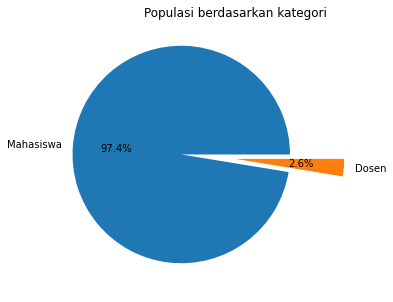

In [ ]:
pie_chart_category = dataset_category['Kategori'].value_counts()

explode = (0.5, 0)
plt.figure(figsize=(20,5))
pie_chart_category.plot(kind='pie', explode=explode,  autopct='%1.1f%%')
plt.ylabel("")
plt.title("Populasi berdasarkan kategori")
plt.show()

### Pie chart responden berdasarkan jenis kelamin

In [ ]:
dataset_category['Jenis Kelamin'].value_counts().to_dict()

{'Laki-laki': 113, 'Perempuan': 42}

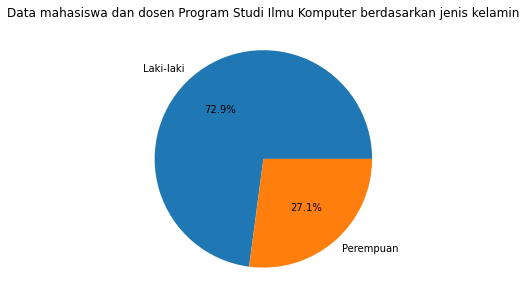

In [ ]:
pie_chart_by_gender = create_pie_chart(dataset_category['Jenis Kelamin'].value_counts().to_dict(), 20,5, 'Data mahasiswa dan dosen Program Studi Ilmu Komputer berdasarkan jenis kelamin')

### Pie chart responden mahasiswa berdasarkan angkatan 

In [ ]:
category_without_dosen = dataset_after_reverse.loc[dataset_after_reverse['Kategori'] != 'Dosen', 'Kategori'].value_counts().to_dict()

In [ ]:
category_without_dosen

{'2021': 45, '2022': 43, '2020': 33, '2019': 30}

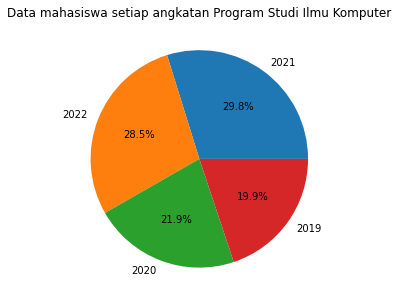

In [ ]:
pie_chart_by_class = create_pie_chart(category_without_dosen, 20,5, 'Data mahasiswa setiap angkatan Program Studi Ilmu Komputer')

### Plot bar jawaban responden setiap kolom 

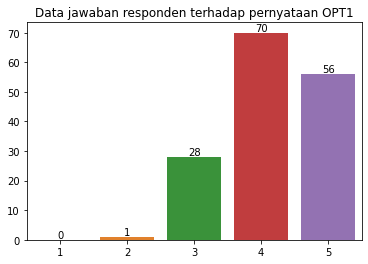

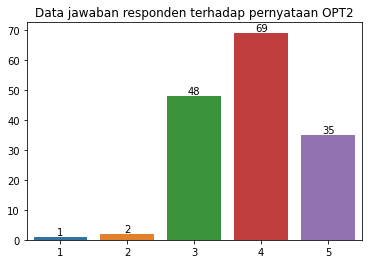

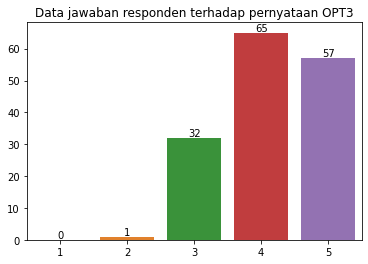

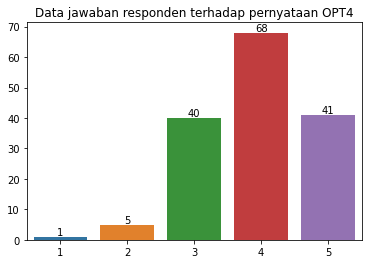

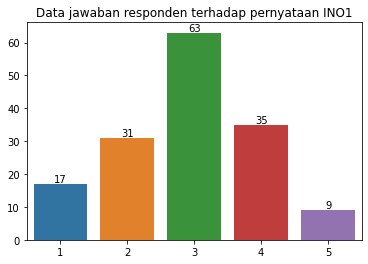

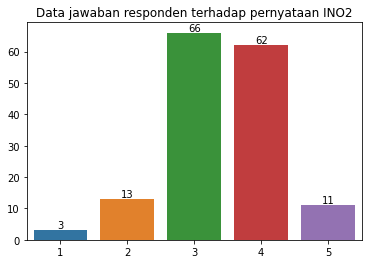

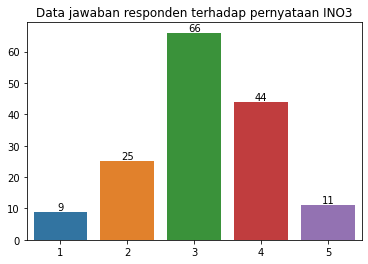

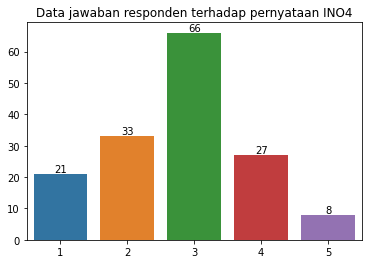

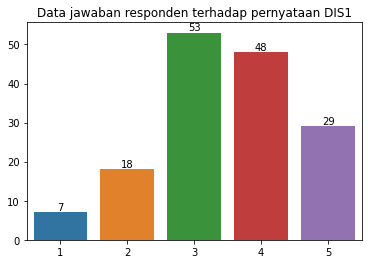

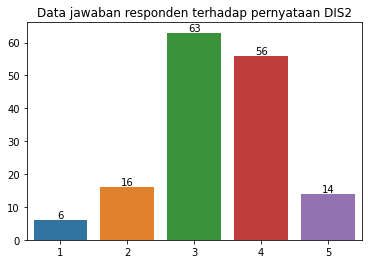

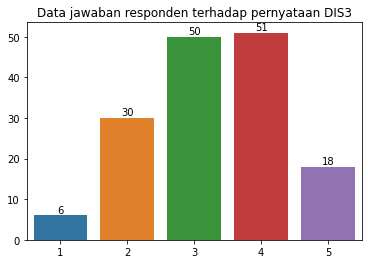

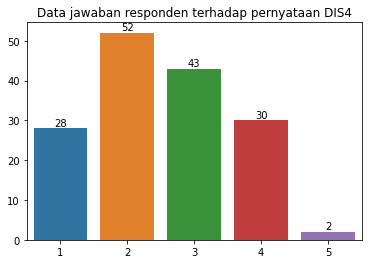

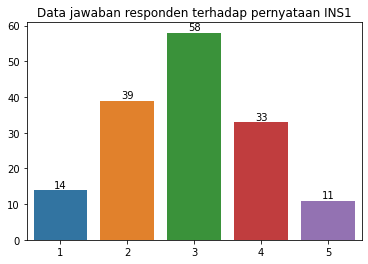

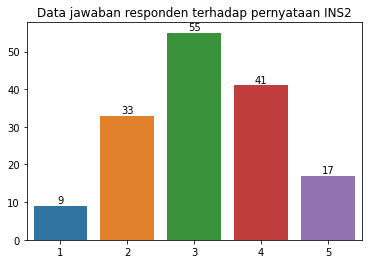

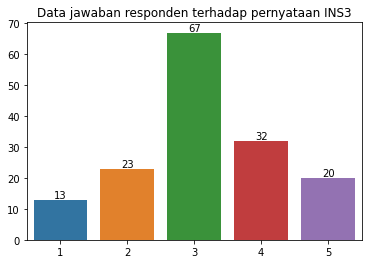

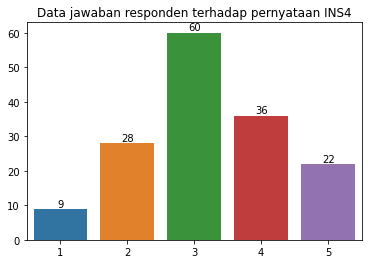

In [ ]:
plot_bar(dataset_after_reverse)

## Class Technology Readiness Index 

In [ ]:
class Technology_Readiness_Index(): 
  
  def result_TRI(self, data): 
    self.data = data 
    
    # 1. Menghitung rata-rata skor jawaban
    result_mean_columns = {}
    for i in range(len(data.columns)):
      kolom = data.columns[i]
      mean, col = self.mean_of_statement(data, kolom)
      result_mean_columns[col] = mean
    print('result mean columns', result_mean_columns)

    # 2. Menghitung bobot masing-masing variabel
    self.count_columns_variables = self.sum_columns(data)
    print('count_columns_variables', self.count_columns_variables)

    # 3. Menghitung bobot pernyataan 
    self.variables_quality = self.quality_of_statement(data)
    print('variables_quality', self.variables_quality)

    # 4. Nilai rata-rata setiap pernyataan 
    result_mean_statement = self.value_of_statement(result_mean_columns)
    print('result_mean_statement\n', result_mean_statement)

    # Membuat plot bar setiap pernyataan 
    plotbar_mean_statement = self.create_plot_bar(result_mean_statement, 15, 5)

    # Nilai TRI per variabel 
    result_index_TRI_by_variable = self.value_variable(result_mean_statement)
    print('\n\nresult_index_TRI_by_variable\n', result_index_TRI_by_variable)
    # print(result_index_TRI_by_variable.values().to_list())

    # Membuat pie chart masing-masing variabel 
    # pie_chart_variable = self.create_pie_chart(result_index_TRI_by_variable, 20, 5, "Grafik Skor TRI")

    index_value_TRI = round(sum(result_index_TRI_by_variable.values()), 3)
    # print("\nNilai TRI ", index_value_TRI)

    check_TRI = self.check_value_TRI(index_value_TRI)
    # print('check TRI', check_TRI)

    # membuat dataframe untuk nilai TRI 
    self.dataframe_TRI = self.result_dataframe(result_index_TRI_by_variable, index_value_TRI, check_TRI)
    # print('dataframe', self.dataframe_TRI)

    return self.dataframe_TRI

  # Fungsi menghitung rata-rata skor jawaban 
  def mean_of_statement(self, data, col): 
    count_1 = 0
    count_2 = 0
    count_3 = 0
    count_4 = 0
    count_5 = 0
    count_list = []
    skala_likert = [1,2,3,4,5]
    # print(skala_likert)

    for label, content in data.iterrows():
      # print(label, content)
      value = content[col]
      if value == 1:
        count_1 += 1
      if value == 2:
        count_2 += 1
      if value == 3:
        count_3 += 1
      if value == 4:
        count_4 += 1
      if value == 5:
        count_5 += 1

    count_list.append(count_1)
    count_list.append(count_2)
    count_list.append(count_3)
    count_list.append(count_4)
    count_list.append(count_5)
    # print()
    # print("List jawaban ", count_list)

    sum_list = sum(count_list)
    # print("Jumlah responden" , sum_list)

    # Menghitung list jawaban dikali dengan jumlah jawaban
    total = 0
    for i in range(len(count_list)):
      result = skala_likert[i] * count_list[i]
      total += result
    # print("Hasil perkalian " , total)

    # mean pernyataan
    mean = total/sum_list
    # print("Nilai mean ", mean)
    return mean, col

  # Fungsi menghitung jumlah kolom setiap variabel 
  def sum_columns(self, data): 
    total_opt_statement = 0
    total_ino_statement = 0
    total_dis_statement = 0
    total_ins_statement = 0

    for i in range(len(data.columns)):
      if 'OPT' in data.columns[i]:
        total_opt_statement += 1
      if 'INO' in data.columns[i]:
        total_ino_statement += 1
      if 'DIS' in data.columns[i]:
        total_dis_statement += 1
      if 'INS' in data.columns[i]:
        total_ins_statement += 1

    return total_opt_statement, total_ino_statement, total_dis_statement, total_ins_statement

  # Fungsi menghitung bobot pernyataan setiap variabel 
  def quality_of_statement(self, data): 
    percent_of_statement = 25/100
    bobot_opt = percent_of_statement / self.count_columns_variables[0]
    bobot_ino = percent_of_statement / self.count_columns_variables[1]
    bobot_dis = percent_of_statement / self.count_columns_variables[2]
    bobot_ins = percent_of_statement / self.count_columns_variables[3]

    return bobot_opt, bobot_ino, bobot_dis, bobot_ins

  # Fungsi menghitung nilai rata-rata setiap variabel  
  def value_of_statement(self, data): 
    list_bobot = []
    for i in range(self.count_columns_variables[0]):
      list_bobot.append(self.variables_quality[0])
    for i in range(self.count_columns_variables[1]):
      list_bobot.append(self.variables_quality[1])
    for i in range(self.count_columns_variables[2]):
      list_bobot.append(self.variables_quality[2])
    for i in range(self.count_columns_variables[3]):
      list_bobot.append(self.variables_quality[3])

    # print(list_bobot)
    # print(result_mean)

    #Mengalikan hasil mean dengan bobot pernyataan
    new_result = {}
    number = 0
    for label, value in data.items():
      result = value * list_bobot[number]
      new_result[label] = result
      number += 1

    return new_result

  # Fungsi membuat plot bar 
  def create_plot_bar(self, data, x, y):
    value = list(data.values())
    keys = list(data.keys())

    fig, ax = plt.subplots(1,1)
    fig.set_figwidth(x)
    fig.set_figheight(y)

    plt.bar(range(len(data)), value, color=sns.color_palette("coolwarm", 16))
    plt.xticks(range(len(data)), keys)
    for i, v in enumerate(value):
      ax.text(i, value[i] + 0.003 , str(round(value[i], 3)), ha='center')

    return plt.show()

  # # Fungsi membuat pie chart 
  # def create_pie_chart(self, data, x, y, title): 
  #   value = list(data.values())
  #   keys = list(data.keys())

  #   fig, ax = plt.subplots(1,1)
  #   fig.set_figwidth(x)
  #   fig.set_figheight(y)

  #   plt.pie(value, labels=keys, autopct='%1.1f%%', colors=sns.color_palette('Paired'))
  #   plt.title(title)
  #   return plt.show()

  # Funsgi menghitung nilai TRI setiap variabel 
  def value_variable(self, data):
    iterator = []
    iterator.append(self.count_columns_variables[0])
    iterator.append(self.count_columns_variables[1])
    iterator.append(self.count_columns_variables[2])
    iterator.append(self.count_columns_variables[3])
    # print('iterator fungsi', iterator)
    iterator_index = 0
    # print('iterator[iterator_index] fungsi', iterator[iterator_index]) 
    pointer = 0 # untuk penanda
    partial_result = 0
    sum_result = {}

    for label, value in data.items():
      # print('value', value)
      new_label = label[:-1]
      # print('new_label', new_label)
      partial_result += value
      # print('partial result', partial_result)
      pointer += 1
      # print('pointer sebelum if', pointer)
      # print('iterator[iterator_index] sebelum if',  iterator[iterator_index])
      if pointer == iterator[iterator_index]:
        # print('pointer', pointer)
        # print('iterator[iterator_index]', iterator[iterator_index])
        sum_result[new_label] = round(partial_result, 3)
        # print('partial result masuk if', partial_result)
        iterator_index += 1
        # print('iterator index masuk if', iterator_index)
        pointer = 0
        partial_result = 0

    return sum_result

  # Fungsi mengecek nilai TRI berdasarkan kategori 
  def check_value_TRI(self, nilai_TRI):
    category_name = ""
    if nilai_TRI <= 2.82:
      category_name = "Low technology readiness"
    elif 2.83 <= nilai_TRI <= 3.24:
      category_name = "Medium technology readiness"
    else:
      category_name = "High technology readiness"

    return category_name

  # membuat dataframe hasil skor indeks TRI 
  def result_dataframe(self, index_TRI_variable, value_TRI, category_TRI): 
    df_result_TRI = pd.DataFrame([index_TRI_variable], columns=index_TRI_variable.keys())
    df_result_TRI['Nilai TRI'] = value_TRI
    df_result_TRI['Kategori'] = category_TRI
    
    return df_result_TRI

## Penghitungan indeks TRI

dataset variabel 

In [ ]:
dataset_variables = dataset_after_reverse.iloc[:, 2:]

In [ ]:
dataset_variables

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


In [ ]:
dataset_variables.to_excel("dataset_variables.xlsx")  

In [ ]:
result_TRI = Technology_Readiness_Index()

result mean columns {'OPT1': 4.167741935483871, 'OPT2': 3.870967741935484, 'OPT3': 4.148387096774194, 'OPT4': 3.92258064516129, 'INO1': 2.92258064516129, 'INO2': 3.4193548387096775, 'INO3': 3.1483870967741936, 'INO4': 2.793548387096774, 'DIS1': 3.47741935483871, 'DIS2': 3.361290322580645, 'DIS3': 3.2903225806451615, 'DIS4': 2.52258064516129, 'INS1': 2.92258064516129, 'INS2': 3.1548387096774193, 'INS3': 3.1483870967741936, 'INS4': 3.2193548387096773}
count_columns_variables (4, 4, 4, 4)
variables_quality (0.0625, 0.0625, 0.0625, 0.0625)
result_mean_statement
 {'OPT1': 0.26048387096774195, 'OPT2': 0.24193548387096775, 'OPT3': 0.2592741935483871, 'OPT4': 0.24516129032258063, 'INO1': 0.18266129032258063, 'INO2': 0.21370967741935484, 'INO3': 0.1967741935483871, 'INO4': 0.17459677419354838, 'DIS1': 0.21733870967741936, 'DIS2': 0.21008064516129032, 'DIS3': 0.2056451612903226, 'DIS4': 0.15766129032258064, 'INS1': 0.18266129032258063, 'INS2': 0.1971774193548387, 'INS3': 0.1967741935483871, 'INS

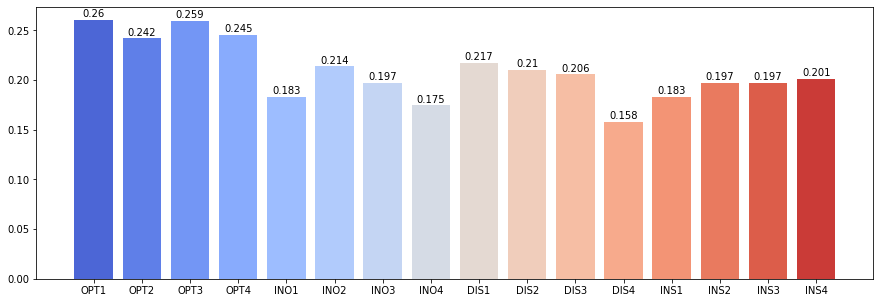



result_index_TRI_by_variable
 {'OPT': 1.007, 'INO': 0.768, 'DIS': 0.791, 'INS': 0.778}


,OPT,INO,DIS,INS,Nilai TRI,Kategori
0,1.007,0.768,0.791,0.778,3.344,High technology readiness


In [ ]:
result_TRI.result_TRI(dataset_variables)

Comparison of the TRI value of the average variable value

In [ ]:
result_TRI_value_of_the_average_variable_value_= TRI_value_of_the_average_variable_value(dataset_variables)
print(result_TRI_value_of_the_average_variable_value_)

3.343


In [ ]:
check_TRI_TRI_value_of_the_average_variable_value = check_value_TRI(result_TRI_value_of_the_average_variable_value_)

Nilai TRI  3.343 -> high technology readiness


# Class KMeans

In [ ]:
class KMeans: 
  def __init__(self, K, max_iters=1000): 
    self.K = K 
    self.max_iters = max_iters 
    self.clusters = [[] for _ in range(K)]
    self.cluster_idx = [[] for _ in range(K)]
    self.centroids = []
    self.init_centroids = [[] for _ in range(K)]
  
  # penghitungan Kmeans 
  def fit(self, X): 
    self.X = X
    n_samples, n_features = X.shape
    # print('n samples', n_samples)
    # print('n features', n_features)

    # 1. inisialisasi random centroid
    np.random.seed(42)
    random_sample_idxs = np.random.choice(n_samples, self.K, replace=False)
    for sample_idx in random_sample_idxs: 
      self.centroids.append(X[sample_idx])
      print('centroid awal', sample_idx, self.centroids)
    self.init_centroids = self.centroids.copy()
    # print('init centroid random', self.init_centroids)

    # 2. Menghitung jarak setiap n_sample ke centroid
    self.iterasi = 0
    for i in range(self.max_iters): 
      # print('\niterasi', iterasi)
      self.clusters, self.cluster_idx = self.assign_sample(self.centroids)
      # print('clusters max iters', i, self.clusters)

      # 3. Menemukan centroid baru 
      old_centroids = self.centroids
      self.centroids = self.find_new_centroid(self.clusters, self.centroids)
      # print('\nold centroids', old_centroids)
      # print('new centroids', self.centroids)

      # 4. Cek apakah sudah converged 
      if self.is_converged(old_centroids, self.centroids, self.K): 
        break

      self.iterasi += 1

    # membuat labels klaster
    self.labels = self.create_labels(self.clusters)
  
    return np.array(self.labels)

  # Membuat klaster 
  def assign_sample(self, centroids): 
    new_cluster = [[] for _ in range(len(self.clusters))]
    cluster_idxs = [[] for _ in range(len(self.clusters))]
    # print('centroid in assign sample', centroids)

    for sample in range(len(self.X)):
      # print('sample', sample, self.X[sample])
      distances = []
      for centroid in centroids: 
        # print('centroid', centroid)
        dist = self.euclidean_distance(self.X[sample], centroid)
        # print(dist)
        distances.append(dist)
      # print('distances', distances)

      min_distance_idx = np.argmin(distances)
      # print('min_distance_idx', min_distance_idx)
      new_cluster[min_distance_idx].append(self.X[sample]) 
      cluster_idxs[min_distance_idx].append(sample) 

    # print('cluster indexes ', cluster_idxs)
    # print('len cluster 0', len(cluster_idxs[0]))
    # print('len cluster 1', len(cluster_idxs[1]))
    # print('len cluster 2', len(cluster_idxs[2]))
    # print('new clusters assign sample', new_cluster)
    return new_cluster, cluster_idxs

  # Penghitungan euclidean distance 
  def euclidean_distance(self, x1, x2): 
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sqrt(np.sum((x1-x2)**2))
  
  # memperbarui titik nilai centroid
  def find_new_centroid(self, clusters, centroids): 
    # print('update centroid baru')
    # print('centroids in find new centroid', centroids)
    new_centroids = [[] for i in range(len(clusters))]
    # print('new_centroid di find new centroid', new_centroids)
    for idx, cluster in enumerate(clusters): 
      # Check jika cluster mempunyai sample
      mean_cluster = []
      if len(cluster) == 0: 
        mean_cluster = centroids[idx]
      else: 
        mean_cluster = self.calculate_mean(cluster)
      
      new_centroids[idx] = mean_cluster
      # print('new_centroids[idx]', new_centroids[idx])
    return new_centroids

  # Menghitung nilai rata-rata klaster 
  def calculate_mean(self, cluster): 
    list_cluster = np.array(cluster)
    row, col = list_cluster.shape
    # print('cluster', list_cluster)
    # print('row', row)
    # print('col', col)
    mean_feature = []
    for feature in range(col): 
      # print('feature', feature)
      sum_feature = 0
      for sample in list_cluster: 
        # print('sample [', feature, ']', sample[feature])
        sum_feature += sample[feature] 
      # print('sum feature', sum_feature, '/', row, '=', sum_feature/row)
      mean_feature.append(sum_feature/row)
    # print('mean_feature', mean_feature)

    return mean_feature

  # mengecek titik nilai centroid berubah
  def is_converged(self, old_centroids, current_centroids, K): 
    # diasumsi kalau old_centroids dan current_centroids mempunyai shape yang sama
    distances = []
    for i in range(K): 
      p = old_centroids[i]
      # print('\nold_centroid', i, old_centroids[i])
      q = current_centroids[i]
      # print('current_centroids', i, current_centroids[i])
      distances.append(self.euclidean_distance(p,q))
      
    return np.sum(distances) == 0

  # membuat labels klaster 
  def create_labels(self, clusters): 
    list_labels = []
    for cluster_idx in range(len(clusters)): 
      # print('cluster', cluster_idx)
      for item in range(len(clusters[cluster_idx])): 
        # print('item cluster', item)
        list_labels.append(cluster_idx)
    
    print(list_labels)
    print()

    cluster_idxs_flatten = pd.DataFrame(np.concatenate(self.cluster_idx).tolist(), columns=['Index in Data'])
    df_labels = pd.DataFrame(list_labels, columns=['Labels'])
    df_result_labels = pd.concat((cluster_idxs_flatten, df_labels),axis=1)
    final_labels = df_result_labels[['Index in Data', 'Labels']].sort_values(by=['Index in Data'])['Labels']
    # print('final_labels', final_labels.tolist())

    return final_labels.tolist()

# KMeans Clustering

In [ ]:
dataset_kmeans = dataset_variables.copy()
dataset_kmeans

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


## Prepocessing Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(dataset_kmeans)

In [ ]:
norm_data

array([[1.        , 1.        , 0.66666667, ..., 1.        , 0.        ,
        0.25      ],
       [1.        , 1.        , 1.        , ..., 0.75      , 0.5       ,
        0.25      ],
       [0.33333333, 0.75      , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.75      ],
       [0.33333333, 0.5       , 0.33333333, ..., 0.75      , 0.75      ,
        0.75      ],
       [1.        , 0.5       , 1.        , ..., 0.75      , 0.75      ,
        0.75      ]])

In [ ]:
pd.DataFrame(norm_data, columns= dataset_kmeans.columns)

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,1.000000,1.00,0.666667,0.75,0.00,0.25,0.00,0.25,0.00,0.75,0.75,0.75,0.00,1.00,0.00,0.25
1,1.000000,1.00,1.000000,1.00,1.00,1.00,1.00,0.50,0.25,0.50,0.75,0.25,0.25,0.75,0.50,0.25
2,0.333333,0.75,1.000000,0.75,0.50,0.25,0.25,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00
3,1.000000,1.00,0.666667,0.75,0.75,0.75,0.50,0.25,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
4,1.000000,0.75,1.000000,1.00,0.50,0.50,0.50,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1.000000,0.00,1.000000,1.00,0.50,1.00,0.75,0.75,0.00,0.00,1.00,0.00,1.00,0.75,0.25,0.25
151,1.000000,0.25,1.000000,0.75,0.75,0.75,0.75,0.75,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.25
152,1.000000,1.00,1.000000,1.00,1.00,1.00,1.00,1.00,0.75,0.75,1.00,0.75,0.75,1.00,1.00,0.75
153,0.333333,0.50,0.333333,0.50,0.00,0.50,0.00,0.00,0.50,0.50,0.50,0.50,0.75,0.75,0.75,0.75


## KMeans

In [ ]:
kmeans_cluster = KMeans(3)

In [ ]:
kmeans_cluster.fit(norm_data)

centroid awal 81 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ])]
centroid awal 142 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ]), array([0.66666667, 0.5       , 0.66666667, 0.25      , 0.5       ,
       0.75      , 0.5       , 0.25      , 0.5       , 0.25      ,
       0.75      , 0.75      , 0.75      , 1.        , 1.        ,
       1.        ])]
centroid awal 31 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ]), array([0.66666667, 0.5       , 0.66666667, 0.25      , 0.5       ,
       0.75      , 0.5       , 0.25      , 0.5       , 0.25      ,
       0.75      , 0.75      , 0.75      , 1.        , 1.        ,
       1.        ]), array([0.66666667, 0.5       , 0.33333333, 0.75      , 0.25      ,
       0.5       , 0.25      , 0.25      , 0.25      , 0.5       ,
       0.5       , 0.        , 

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2,
       0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 0, 1, 2,
       2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 1,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2,
       1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 0, 0, 1, 0, 2, 0, 1,
       0])

In [ ]:
kmeans_cluster.clusters

[[array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.5 , 0.25, 0.5 , 0.75,
         0.25, 0.25, 0.75, 0.5 , 0.25]),
  array([1.        , 1.        , 0.66666667, 0.75      , 0.75      ,
         0.75      , 0.5       , 0.25      , 0.75      , 0.75      ,
         0.75      , 0.75      , 0.75      , 0.75      , 0.75      ,
         0.75      ]),
  array([1.  , 0.75, 1.  , 0.75, 0.75, 1.  , 1.  , 0.75, 0.5 , 0.75, 1.  ,
         0.25, 0.75, 0.75, 0.5 , 0.25]),
  array([0.66666667, 0.75      , 1.        , 1.        , 0.25      ,
         0.5       , 0.75      , 0.25      , 0.5       , 0.75      ,
         0.75      , 0.        , 0.25      , 0.25      , 0.75      ,
         1.        ]),
  array([1.        , 1.        , 0.66666667, 0.75      , 0.5       ,
         0.75      , 1.        , 0.5       , 0.75      , 0.5       ,
         0.5       , 0.25      , 0.5       , 0.5       , 0.25      ,
         1.        ]),
  array([0.66666667, 0.75      , 0.66666667, 0.75      , 0.5       ,
         

In [ ]:
kmeans_cluster.centroids

[[0.9215686274509803,
  0.8333333333333334,
  0.8954248366013071,
  0.8578431372549019,
  0.6421568627450981,
  0.7401960784313726,
  0.7058823529411765,
  0.5637254901960784,
  0.7303921568627451,
  0.7156862745098039,
  0.7598039215686274,
  0.3872549019607843,
  0.5784313725490197,
  0.6764705882352942,
  0.6519607843137255,
  0.6862745098039216],
 [0.5675675675675675,
  0.6418918918918919,
  0.6036036036036038,
  0.6351351351351351,
  0.24324324324324326,
  0.5202702702702703,
  0.3310810810810811,
  0.18243243243243243,
  0.777027027027027,
  0.6283783783783784,
  0.5945945945945946,
  0.3918918918918919,
  0.6486486486486487,
  0.6418918918918919,
  0.668918918918919,
  0.6486486486486487],
 [0.6567164179104477,
  0.6716417910447762,
  0.6417910447761194,
  0.6865671641791045,
  0.48880597014925375,
  0.5485074626865671,
  0.5223880597014925,
  0.5074626865671642,
  0.44776119402985076,
  0.47388059701492535,
  0.417910447761194,
  0.3694029850746269,
  0.31343283582089554,
  0.3

## Elbow Method

In [ ]:
def distance_elbow(x1, x2):
  return np.sum((x1-x2)**2)

def calculate_sse(clusters, centroids):
  sse = []
  for index, cluster in enumerate(clusters):
    distances = 0
    for sample_idx, sample in enumerate(cluster):
      dist = distance_elbow(sample, centroids[index])
      distances += dist
    sse.append(distances)

  return np.sum(sse)

In [ ]:
def create_elbow_method(list_data): 
  global initial_centroid
  list_sse = []
  total_iterasi = 0
  for i in range(1,6):
    print('K =', i)
    kmeans_cluster = KMeans(i)
    kmeans_cluster.fit(list_data)
    sse = round(calculate_sse(kmeans_cluster.clusters, kmeans_cluster.centroids), 4)
    list_sse.append(sse)
    total_iterasi += kmeans_cluster.iterasi

    # print('total_iterasi', total_iterasi)
  
  initial_centroid = kmeans_cluster.init_centroids 
  
  print('List SSE', list_sse)
  print('total iterasi', total_iterasi)
  # print(initial_centroid)

  plt.plot(range(1,6), list_sse, 'bx-')
  plt.xticks(range(1,6))
  plt.title("Elbow Method")
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  
  return plt.show()

K = 1
centroid awal 81 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ])]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

K = 2
centroid awal 81 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ])]
centroid awal 142 [array([1.  , 1.  , 1.  , 0.5 , 0.5 , 0.75, 0.75, 0.5 , 0.5 , 0.75, 1.  ,
       0.  , 0.5 , 1.  , 1.  , 0.5 ]), array([0.66666667, 0.5       , 0.66666667, 0.25      , 0.5       ,
       0.75      , 0.5       , 0.25      , 0.5       , 0.25    

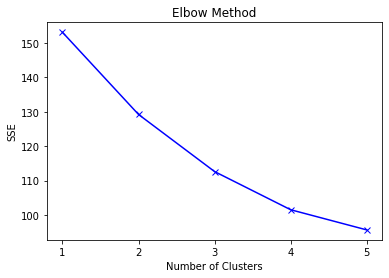

In [ ]:
create_elbow_method(norm_data)

## Hasil Klasters

In [ ]:
data_kmeans_with_labels = dataset_kmeans.copy()

In [ ]:
data_kmeans_with_labels['Labels'] = kmeans_cluster.labels

In [ ]:
data_kmeans_with_labels

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4,Labels
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2,0
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1,2
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4,0
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2,0
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4,0
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4,1


#### Jumlah anggota klaster

In [ ]:
label_name = data_kmeans_with_labels['Labels'].value_counts().sort_index().to_dict()

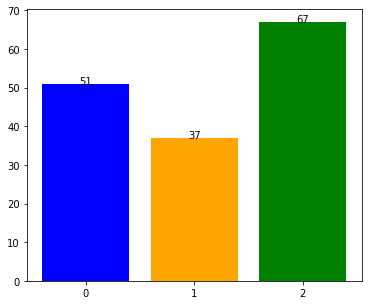

In [ ]:
create_plot_bar(label_name, 6,5, color_palette=['blue', 'orange', 'green'])

### Rata-rata klaster

In [ ]:
def describe_cluster(dataframe_cluster):
  cluster = sum_variable(dataframe_cluster)
  print(cluster)
  desc_cluster = cluster.describe(percentiles=[]).round(3)
  desc_cluster = desc_cluster.drop('50%')

  return desc_cluster

#### Klaster 0 

In [ ]:
cluster_0 = data_kmeans_with_labels.loc[data_kmeans_with_labels['Labels'] == 0]

In [ ]:
describe_cluster(cluster_0)

    Total OPT  Total INO  Total DIS  Total INS
0          20         18         11         11
1          18         13         16         16
2          18         18         14         13
3          18         11         12         13
4          18         15         12         13
5          16         13         14         13
6          18         11         13         12
7          16         15         13         17
8          18         17         12         13
9          20         16         16         13
10         20         14         16         12
11         19         16         14         16
12         18         13         17         14
13         16         13         15         18
14         18         17         14         14
15         18         13         18         17
16         19         11         16         16
17         16         17         16         14
18         19         17         14         15
19         18         13         15         14
20         14

,Total OPT,Total INO,Total DIS,Total INS
count,51.000,51.000,51.000,51.000
mean,18.216,14.608,14.373,14.373
std,1.501,2.098,2.653,3.046
min,14.000,11.000,8.000,4.000
max,20.000,20.000,20.000,20.000


In [ ]:
cluster_0.to_excel("cluster_0.xlsx")  

#### Klaster 1 

In [ ]:
cluster_1 = data_kmeans_with_labels.loc[data_kmeans_with_labels['Labels'] == 1]

In [ ]:
describe_cluster(cluster_1)

    Total OPT  Total INO  Total DIS  Total INS
0          16         10         12         16
1          14         12         14         15
2          15          9         15         15
3          16         10         16         12
4          17          9         13         14
5          16          9         11         12
6          13          9         13         16
7          15          7         15         12
8          12          7         20         12
9          16          7         14         13
10         17          6         11         15
11         14          8         13         11
12         12         11         12         13
13         12          6         12         12
14         14          4         13         17
15         18          9         13         11
16         16         11         11         14
17         15          6         17         17
18         14         10         14         15
19         15         13         15         14
20         19

,Total OPT,Total INO,Total DIS,Total INS
count,37.000,37.000,37.000,37.000
mean,14.622,9.108,13.568,14.432
std,1.949,2.221,1.951,2.352
min,11.000,4.000,10.000,11.000
max,19.000,14.000,20.000,19.000


In [ ]:
cluster_1.to_excel("cluster_1.xlsx")  

#### Klaster 2

In [ ]:
cluster_2 = data_kmeans_with_labels.loc[data_kmeans_with_labels['Labels'] == 2]

In [ ]:
describe_cluster(cluster_2)

    Total OPT  Total INO  Total DIS  Total INS
0          18          6         13          9
1          16          8          6          4
2          19         11         11         12
3          15         14         12         10
4          16         14         10          9
..        ...        ...        ...        ...
62         15          9         12          7
63         12         12         12         12
64         20         15          6         12
65         15         16          8         14
66         16         16          9          8

[67 rows x 4 columns]


,Total OPT,Total INO,Total DIS,Total INS
count,67.000,67.000,67.000,67.000
mean,15.328,12.269,10.836,9.881
std,2.383,2.502,2.661,2.585
min,9.000,6.000,4.000,4.000
max,20.000,20.000,17.000,14.000


In [ ]:
cluster_2.to_excel("cluster_2.xlsx")  

### Kategori berdasarkan rata-rata

In [ ]:
def category_mean(dataframe_cluster): 
  # mean_cluster = sum_variable(dataframe_cluster)
  df_cluster = pd.DataFrame(sum_variable(dataframe_cluster).mean()).T
  df_cluster.columns.name = 'Cluster'
  # print(df_cluster)

  for i in range(len(df_cluster.columns)):
    column_variable = df_cluster.columns[i]
    # print(column_variable)
    for label, content in df_cluster.iterrows():  
      value = content[i]
      if column_variable == 'Total OPT' or column_variable == 'Total INO':
        # print('masuk') 
        if value <= 11.9: 
          df_cluster[column_variable] = df_cluster[column_variable].replace(value, 'Rendah')
        else:
          df_cluster[column_variable] = df_cluster[column_variable].replace(value, 'Tinggi')
      else: 
        if value <= 11.9: 
          df_cluster[column_variable] = df_cluster[column_variable].replace(value, 'Tinggi')
        else:
          df_cluster[column_variable] = df_cluster[column_variable].replace(value, 'Rendah')


  cluster_name = df_cluster.to_numpy().tolist()
  # print('cluster name to list', cluster_name)

  # dict category cluster 
  cluster_dict = {'Explorers': ['Tinggi', 'Tinggi', 'Rendah', 'Rendah'], 
                'Pioneers': ['Tinggi', 'Tinggi', 'Tinggi', 'Tinggi'], 
                'Skeptics' : ['Rendah', 'Rendah', 'Rendah', 'Rendah'], 
                'Hesitators' : ['Tinggi', 'Rendah', 'Tinggi', 'Tinggi'], 
                'Avoiders' : ['Rendah', 'Rendah', 'Tinggi', 'Tinggi']}

  key_list = list(cluster_dict.keys())
  value_list = list(cluster_dict.values())
  ts_list = []

  for cluster_detail in cluster_name: 
    if cluster_detail in cluster_dict.values(): 
      index = value_list.index(cluster_detail)
      ts_list.append(key_list[index])
      # print(key_list[index])
      # print('ts list', ts_list)
    else: 
      ts_list.append('New Cluster')

  df_cluster['Technology_Segmentation'] = ts_list

  return df_cluster

In [ ]:
def append_to_df_tech_segmen(category_cluster0, category_cluster1, category_cluster2): 
  cluster0 = category_mean(category_cluster0)
  cluster0_and_cluster1 = cluster0.append(category_mean(category_cluster1))
  final_cluster = cluster0_and_cluster1.append(category_mean(category_cluster2))

  final_cluster.index = ['0', '1', '2']

  return final_cluster

In [ ]:
final_category_mean = append_to_df_tech_segmen(cluster_0, cluster_1, cluster_2)

In [ ]:
final_category_mean

Cluster,Total OPT,Total INO,Total DIS,Total INS,Technology_Segmentation
0,Tinggi,Tinggi,Rendah,Rendah,Explorers
1,Tinggi,Rendah,Rendah,Rendah,New Cluster
2,Tinggi,Tinggi,Tinggi,Tinggi,Pioneers


In [ ]:
tech_segmen = final_category_mean['Technology_Segmentation'].tolist()

list_tech_segmen = []

for label in data_kmeans_with_labels['Labels']: 
  # print(tech_segmen[label])
  list_tech_segmen.append(tech_segmen[label])

data_kmeans_with_labels['Technology_Segmentation'] = list_tech_segmen

In [ ]:
data_kmeans_with_labels

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4,Labels,Technology_Segmentation
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2,2,Pioneers
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2,0,Explorers
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1,2,Pioneers
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4,0,Explorers
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4,2,Pioneers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2,0,Explorers
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2,2,Pioneers
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4,0,Explorers
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4,1,New Cluster


### Nama klaster

In [ ]:
df_cluster = data_kmeans_with_labels.copy()

In [ ]:
cluster_name = df_cluster['Technology_Segmentation'].value_counts().sort_index().to_dict()

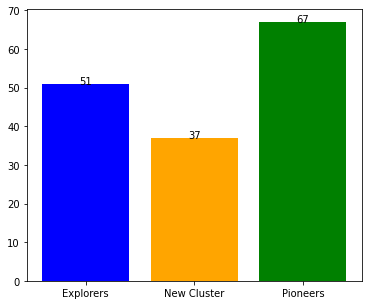

In [ ]:
create_plot_bar(cluster_name, 6,5, color_palette=['blue', 'orange', 'green'])

In [ ]:
def count_sample_cluster(dataframe_cluster, dataframe_category): 
  result_cluster_segmentation = dataframe_cluster['Technology_Segmentation'].value_counts().sort_index(ascending=True).to_dict()
  print(result_cluster_segmentation)
  percent_cluster = dataframe_cluster['Technology_Segmentation'].value_counts(normalize=True).sort_index(ascending=True).to_dict()
  print(percent_cluster)

  dataframe_category['Count'] = dataframe_category['Technology_Segmentation'].map(result_cluster_segmentation)
  dataframe_category['Percent'] = round(dataframe_category['Technology_Segmentation'].map(percent_cluster) * 100, 0)
  dataframe_category.index = ['0', '1', '2']

  return dataframe_category

In [ ]:
result_count_cluster = count_sample_cluster(df_cluster, final_category_mean)

{'Explorers': 51, 'New Cluster': 37, 'Pioneers': 67}
{'Explorers': 0.32903225806451614, 'New Cluster': 0.23870967741935484, 'Pioneers': 0.432258064516129}


In [ ]:
result_count_cluster.sort_values(by='Count', ascending=False)

Cluster,Total OPT,Total INO,Total DIS,Total INS,Technology_Segmentation,Count,Percent
2,Tinggi,Tinggi,Tinggi,Tinggi,Pioneers,67,43.0
0,Tinggi,Tinggi,Rendah,Rendah,Explorers,51,33.0
1,Tinggi,Rendah,Rendah,Rendah,New Cluster,37,24.0


In [ ]:
result_count_cluster

Cluster,Total OPT,Total INO,Total DIS,Total INS,Technology_Segmentation,Count,Percent
0,Tinggi,Tinggi,Rendah,Rendah,Explorers,51,33.0
1,Tinggi,Rendah,Rendah,Rendah,New Cluster,37,24.0
2,Tinggi,Tinggi,Tinggi,Tinggi,Pioneers,67,43.0


# Library Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Nominal encoder 

In [ ]:
data_tester_with_library = dataset_variables.copy()

In [ ]:
data_tester_with_library

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


In [ ]:
scaler = MinMaxScaler()
norm_data_library = scaler.fit_transform(data_tester_with_library)

In [ ]:
standarscaler = StandardScaler()
scaler_data_library = standarscaler.fit_transform(data_tester_with_library)

In [ ]:
scaler_data_library

array([[ 1.13297467,  1.4241298 , -0.19518177, ...,  1.7400895 ,
        -1.97404618, -1.12981389],
       [ 1.13297467,  1.4241298 ,  1.12017365, ...,  0.797034  ,
        -0.13634553, -1.12981389],
       [-1.58967763,  0.16275769,  1.12017365, ..., -2.03213249,
        -1.97404618, -2.05638083],
       ...,
       [ 1.13297467,  1.4241298 ,  1.12017365, ...,  1.7400895 ,
         1.70135511,  0.72332   ],
       [-1.58967763, -1.09861442, -1.51053719, ...,  0.797034  ,
         0.78250479,  0.72332   ],
       [ 1.13297467, -1.09861442,  1.12017365, ...,  0.797034  ,
         0.78250479,  0.72332   ]])

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=1000, init=np.asarray(initial_centroid[0:3])).fit(norm_data_library)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [ ]:
kmeans_library = KMeans(n_clusters=3, max_iter=1000, random_state=42).fit(norm_data_library)

### Elbow Method

In [ ]:
def sse_library(data_library): 
  sse = []
  for k in range(1,6): 
    model_kmeans = KMeans(n_clusters=k, max_iter=1000, init=np.asarray(initial_centroid[0:k])).fit(data_library)
    sse.append(model_kmeans.inertia_)
  print(sse)

  plt.plot(range(1,6), sse, 'bx-')
  plt.xticks(range(1,6))
  plt.title("Elbow Method")
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")

  return plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMe

[153.0481182795699, 129.2019878269878, 112.62381004797598, 101.55178004920043, 95.70163220434955]


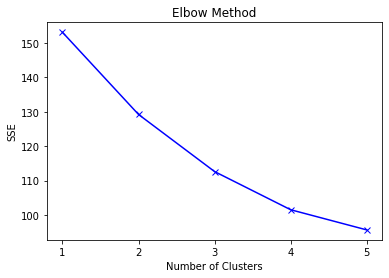

In [ ]:
sse_library(norm_data_library)

[153.0481182795699, 126.8788161906887, 109.7234395878302, 101.56862090455837, 95.32612068733197]


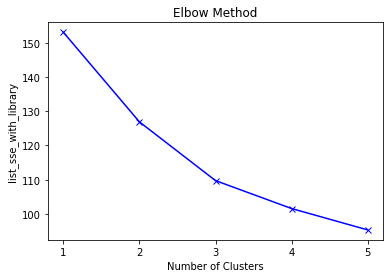

In [ ]:
list_sse_with_library = []
for k in range(1,6): 
  model_kmeans_library = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(norm_data_library)
  list_sse_with_library.append(model_kmeans_library.inertia_)
print(list_sse_with_library)

plt.plot(range(1,6), list_sse_with_library, 'bx-')
plt.xticks(range(1,6))
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("list_sse_with_library")
plt.show()

[2479.999999999999, 2064.5962787574217, 1787.9452817535553, 1663.3180866869657, 1563.9480540287914]


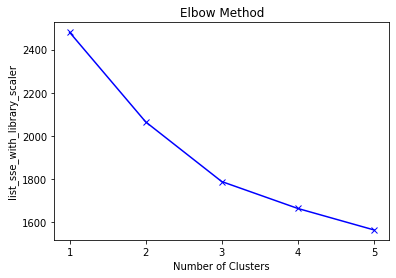

In [ ]:
list_sse_with_library_scaler = []
for k in range(1,6): 
  model_kmeans_scaler = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(scaler_data_library)
  list_sse_with_library_scaler.append(model_kmeans_scaler.inertia_)
print(list_sse_with_library_scaler)

plt.plot(range(1,6), list_sse_with_library_scaler, 'bx-')
plt.xticks(range(1,6))
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("list_sse_with_library_scaler")
plt.show()

### Silhoutte Score

In [ ]:
from sklearn.metrics import silhouette_score

[0.1516457957053684, 0.15241275742129293, 0.13942265951169974, 0.13741808989693058, 0.1285887248726389]


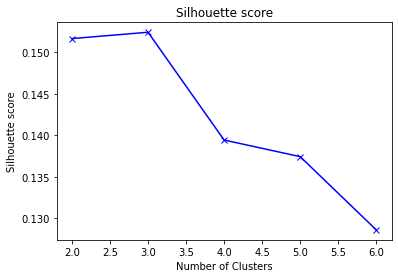

In [ ]:
list_silhouette_score = []
ks = [2,3,4,5,6]

for k in ks: 
  model_kmeans_silhouette = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(norm_data_library)
  cluster_labels = model_kmeans_silhouette.labels_

  list_silhouette_score.append(silhouette_score(norm_data_library, cluster_labels))
print(list_silhouette_score)

plt.plot(ks, list_silhouette_score, 'bx-')
plt.title("Silhouette score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette score")
plt.show()

### KMeans

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=1000, init=np.asarray(initial_centroid[0:3])).fit(norm_data_library)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [ ]:
labels = pd.DataFrame(kmeans.labels_, columns=['Labels'])

In [ ]:
kmeans.labels_

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2,
       0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 0, 1, 2,
       2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 1,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2,
       1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 0, 0, 1, 0, 2, 0, 1,
       0], dtype=int32)

In [ ]:
centroids_with_library = kmeans.cluster_centers_

In [ ]:
centroids_with_library

array([[0.92156863, 0.83333333, 0.89542484, 0.85784314, 0.64215686,
        0.74019608, 0.70588235, 0.56372549, 0.73039216, 0.71568627,
        0.75980392, 0.3872549 , 0.57843137, 0.67647059, 0.65196078,
        0.68627451],
       [0.56756757, 0.64189189, 0.6036036 , 0.63513514, 0.24324324,
        0.52027027, 0.33108108, 0.18243243, 0.77702703, 0.62837838,
        0.59459459, 0.39189189, 0.64864865, 0.64189189, 0.66891892,
        0.64864865],
       [0.65671642, 0.67164179, 0.64179104, 0.68656716, 0.48880597,
        0.54850746, 0.52238806, 0.50746269, 0.44776119, 0.4738806 ,
        0.41791045, 0.36940299, 0.31343284, 0.37686567, 0.37686567,
        0.40298507]])

### Cluster

In [ ]:
result_data_library_with_labels = pd.concat((data_tester_with_library, labels), axis=1)

In [ ]:
result_data_library_with_labels

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4,Labels
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2,0
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1,2
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4,0
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2,0
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4,0
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4,1


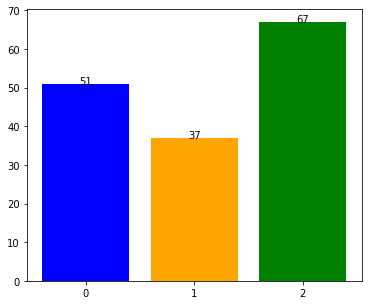

In [ ]:
label_name_with_library = result_data_library_with_labels['Labels'].value_counts().sort_index().to_dict()

create_plot_bar(label_name_with_library, 6,5, color_palette=['blue', 'orange', 'green'])

#### Cluster 0

In [ ]:
cluster0_library = result_data_library_with_labels.loc[result_data_library_with_labels['Labels'] == 0]

In [ ]:
describe_cluster(cluster0_library)

    Total OPT  Total INO  Total DIS  Total INS
0          20         18         11         11
1          18         13         16         16
2          18         18         14         13
3          18         11         12         13
4          18         15         12         13
5          16         13         14         13
6          18         11         13         12
7          16         15         13         17
8          18         17         12         13
9          20         16         16         13
10         20         14         16         12
11         19         16         14         16
12         18         13         17         14
13         16         13         15         18
14         18         17         14         14
15         18         13         18         17
16         19         11         16         16
17         16         17         16         14
18         19         17         14         15
19         18         13         15         14
20         14

,Total OPT,Total INO,Total DIS,Total INS
count,51.000,51.000,51.000,51.000
mean,18.216,14.608,14.373,14.373
std,1.501,2.098,2.653,3.046
min,14.000,11.000,8.000,4.000
max,20.000,20.000,20.000,20.000


#### Cluster 1

In [ ]:
cluster1_library = result_data_library_with_labels.loc[result_data_library_with_labels['Labels'] == 1]

In [ ]:
describe_cluster(cluster1_library)

    Total OPT  Total INO  Total DIS  Total INS
0          16         10         12         16
1          14         12         14         15
2          15          9         15         15
3          16         10         16         12
4          17          9         13         14
5          16          9         11         12
6          13          9         13         16
7          15          7         15         12
8          12          7         20         12
9          16          7         14         13
10         17          6         11         15
11         14          8         13         11
12         12         11         12         13
13         12          6         12         12
14         14          4         13         17
15         18          9         13         11
16         16         11         11         14
17         15          6         17         17
18         14         10         14         15
19         15         13         15         14
20         19

,Total OPT,Total INO,Total DIS,Total INS
count,37.000,37.000,37.000,37.000
mean,14.622,9.108,13.568,14.432
std,1.949,2.221,1.951,2.352
min,11.000,4.000,10.000,11.000
max,19.000,14.000,20.000,19.000


#### Cluster 2

In [ ]:
cluster2_library = result_data_library_with_labels.loc[result_data_library_with_labels['Labels'] == 2]

In [ ]:
describe_cluster(cluster2_library)

    Total OPT  Total INO  Total DIS  Total INS
0          18          6         13          9
1          16          8          6          4
2          19         11         11         12
3          15         14         12         10
4          16         14         10          9
..        ...        ...        ...        ...
62         15          9         12          7
63         12         12         12         12
64         20         15          6         12
65         15         16          8         14
66         16         16          9          8

[67 rows x 4 columns]


,Total OPT,Total INO,Total DIS,Total INS
count,67.000,67.000,67.000,67.000
mean,15.328,12.269,10.836,9.881
std,2.383,2.502,2.661,2.585
min,9.000,6.000,4.000,4.000
max,20.000,20.000,17.000,14.000


## Pakai Library tanpa nominal encoder

In [ ]:
data_tester_without_nominal_encoder = data_tester_with_library.copy()

In [ ]:
data_tester_without_nominal_encoder

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4


[2314.0387096774193, 1905.1767068273089, 1701.3152613206553, 1552.4100538508433, 1533.3813170220635]


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMe

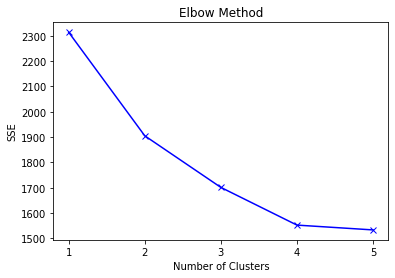

In [ ]:
sse_library(data_tester_without_nominal_encoder)

In [ ]:
# np.random.seed(42)

In [ ]:
kmeans_without_norm = KMeans(n_clusters=3, max_iter=1000, random_state=42).fit(data_tester_without_nominal_encoder)

In [ ]:
labels_without_norm = kmeans_without_norm.labels_
print(labels_without_norm)

[1 0 0 2 0 0 1 0 2 2 1 2 0 0 2 1 1 1 0 1 1 0 2 0 1 2 1 0 2 1 1 0 0 0 2 2 1
 2 1 2 2 1 2 2 1 2 2 2 0 1 1 1 0 1 1 0 0 0 1 2 0 0 0 1 1 0 0 2 0 1 1 1 0 2
 1 1 1 0 2 1 1 2 0 2 1 2 1 0 1 1 1 2 1 2 1 1 0 1 0 2 1 0 0 1 2 0 2 1 1 1 0
 1 2 2 2 0 0 2 2 1 1 2 0 0 1 1 1 0 0 2 1 1 1 1 2 1 0 1 2 1 1 2 1 1 1 0 0 2
 2 1 0 0 2 1 2]


In [ ]:
centroids_with_library_without_norm = kmeans_without_norm.cluster_centers_

In [ ]:
centroids_with_library_without_norm

array([[4.34782609, 3.95652174, 4.36956522, 4.32608696, 3.43478261,
        3.52173913, 3.39130435, 3.41304348, 2.67391304, 2.76086957,
        2.7826087 , 2.10869565, 2.        , 2.36956522, 2.34782609,
        2.41304348],
       [3.67692308, 3.47692308, 3.66153846, 3.38461538, 2.13846154,
        3.04615385, 2.6       , 2.09230769, 3.56923077, 3.35384615,
        3.13846154, 2.72307692, 3.18461538, 3.24615385, 3.24615385,
        3.23076923],
       [4.70454545, 4.36363636, 4.63636364, 4.29545455, 3.54545455,
        3.86363636, 3.70454545, 3.18181818, 4.18181818, 4.        ,
        4.04545455, 2.65909091, 3.5       , 3.84090909, 3.84090909,
        4.04545455]])

In [ ]:
labels_without_norm = pd.DataFrame(kmeans_without_norm.labels_, columns=['Labels'])

In [ ]:
result_without_norm = pd.concat((data_tester_without_nominal_encoder, labels_without_norm), axis=1)

In [ ]:
result_without_norm

,OPT1,OPT2,OPT3,OPT4,INO1,INO2,INO3,INO4,DIS1,DIS2,DIS3,DIS4,INS1,INS2,INS3,INS4,Labels
0,5,5,4,4,1,2,1,2,1,4,4,4,1,5,1,2,1
1,5,5,5,5,5,5,5,3,2,3,4,2,2,4,3,2,0
2,3,4,5,4,3,2,2,1,1,3,1,1,1,1,1,1,0
3,5,5,4,4,4,4,3,2,4,4,4,4,4,4,4,4,2
4,5,4,5,5,3,3,3,2,3,2,3,3,3,3,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,5,5,3,5,4,4,1,1,5,1,5,4,2,2,0
151,5,2,5,4,4,4,4,4,3,2,2,2,2,2,2,2,0
152,5,5,5,5,5,5,5,5,4,4,5,4,4,5,5,4,2
153,3,3,3,3,1,3,1,1,3,3,3,3,4,4,4,4,1


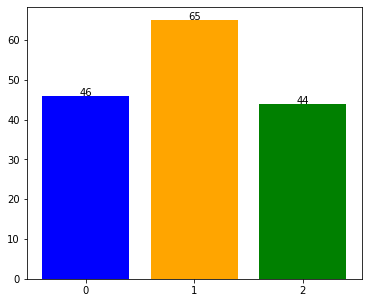

In [ ]:
label_name_without_norm = result_without_norm['Labels'].value_counts().sort_index().to_dict()

create_plot_bar(label_name_without_norm, 6,5, color_palette=['blue', 'orange', 'green'])